In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt # to plot charts

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.
# from tensorflow import set_random_seed

seed = 108
np.random.RandomState(seed)
# set_random_seed(seed)

/kaggle/input/fashionmnist/t10k-labels-idx1-ubyte
/kaggle/input/fashionmnist/train-labels-idx1-ubyte
/kaggle/input/fashionmnist/train-images-idx3-ubyte
/kaggle/input/fashionmnist/fashion-mnist_test.csv
/kaggle/input/fashionmnist/fashion-mnist_train.csv
/kaggle/input/fashionmnist/t10k-images-idx3-ubyte


RandomState(MT19937) at 0x7F6AA9546678

In [2]:
# Kers modules
from keras.optimizers import SGD
from keras.models import Sequential
from keras.utils import to_categorical
from keras.layers.normalization import BatchNormalization
from keras.layers import Dense, Dropout, Conv2D, Flatten, MaxPool2D
from keras.callbacks import EarlyStopping, History, LearningRateScheduler

Using TensorFlow backend.


# Load & Prepare Data

In [3]:
# path where the dataset is kept
data_dir = "/kaggle/input/fashionmnist/"

In [4]:
# read the data from the csv
train_df = pd.read_csv(data_dir+"fashion-mnist_train.csv")
train_df.head(2)

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
# check the number of rows and columns
train_df.shape

(60000, 785)

In [6]:
# extract the labels from the dataframe
y = train_df.values[:, 0]

# convert the y to categorical using one-hot encoding
y = to_categorical(y)
print("Shape of y: ", y.shape)
print("Sample of y: ", y[0])

Shape of y:  (60000, 10)
Sample of y:  [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


Shape of X:  (60000, 28, 28, 1)
Sample of X: 


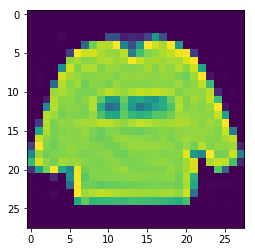

In [7]:
# extract the pixel values from the dataframe
X = train_df.values[:, 1:]/255.0 # all the columns but 1st

# reshape each row into 28x28 size
X = X.reshape(-1, 28, 28, 1) # -1 tells the system to automatically figure out the size of the first dimention

print("Shape of X: ", X.shape)
print("Sample of X: ")
plt.imshow(X[0].reshape(28, 28))

In [8]:
# split the data into train(70%) and test (30%)
validation_split = .3

# stratify makes sure that data of all the classes - Tshirt, Trouser, etc. are split equally between train and test
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=validation_split, stratify=y, random_state=seed)

In [9]:
print(X_train.shape, y_train.shape)

(42000, 28, 28, 1) (42000, 10)


In [10]:
print(X_val.shape, y_val.shape)

(18000, 28, 28, 1) (18000, 10)


# Build the network

**Below are the parameters that we can tweak to boost the performance of our CNN**
* Number of Convolution layers
* Number of Feature maps
* Size of the Dense layer
* % of Drop-Out 

**Also, some of the following advance features canbe manipulated to increase the efficiency**
* replace '32C5' with '32C3-32C3'
* replace 'P2' with '32C5S2'
* add batch normalization
* add data augmentation

reference: [https://www.kaggle.com/cdeotte/how-to-choose-cnn-architecture-mnist]

In [11]:
class CNN_Modeling():
    
    def __init__(self, model_confs):
        self.epochs = 30
        self.batch_size = 80
        self.annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x, verbose=0)
        
        self.models = []
        self.history = []
        self.model_names = []
        self.model_confs = model_confs
    
    def build_models(self, feature_maps, kernel_size, dense_size, drop_rate):
        model = Sequential()

        # add the convolution and max pool layers with provided kernel_size
        for i, fm in enumerate(feature_maps):
            # add conv layer
            model.add(Conv2D(fm, kernel_size=kernel_size, padding='same', activation='relu', input_shape=(28, 28, 1)))

            # add MaxPool
            if i == len(feature_maps)-1:
                model.add(MaxPool2D())
            else:
                model.add(MaxPool2D(padding='same'))

            # add the Dropout
            model.add(Dropout(drop_rate))

        # convert the output from the convolution layers into a linear array
        model.add(Flatten())

        # add a dense layer with size - dense_size
        for dns in dense_size:
            if dns>0:
                model.add(Dense(dns, activation='relu'))
                model.add(Dropout(drop_rate))

        # add the final softmax layer with size equal to the number of categories
        model.add(Dense(10, activation='softmax'))

        # compile the model
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

        # return the model
        return model
    
    
    def get_model_name(self, conf):
        # add the convolution layers name
        name = "-".join(
            ["{}C{}P1".format(ft, conf['kernel_size']) for ft in conf['feature_maps']])

        # add the dense layer size
        name = name + "-" + "-".join(map(str, conf['dense_size']))

        # add the drop out
        name = name + '-D%d'%round(conf["drop_rate"]*100)

        return name    
    
    
    def train_models(self, _x_train, _y_train, _x_val, _y_val):
        # to store the models and their history
        self.models = [None]*len(self.model_confs)
        self.history = [None]*len(self.model_confs)
        self.model_names = [None]*len(self.model_confs)
        
        for i, model_conf in enumerate(self.model_confs):
            
            # create the model
            self.models[i] = self.build_models(**model_conf)
            
            # get and store the model name
            self.model_names[i] = self.get_model_name(model_conf)

            # fir the model
            self.history[i] = self.models[i].fit(_x_train,_y_train, batch_size=self.batch_size, epochs=self.epochs, 
                          validation_data = (_x_val,_y_val), callbacks=[self.annealer], verbose=0)

            print("CNN {0}: Epochs={1:d}, Train accuracy={2:.5f}, Validation accuracy={3:.5f}".format(
                self.model_names[i], self.epochs, max(self.history[i].history['accuracy']), 
                max(self.history[i].history['val_accuracy']))
            )
            
            
    def plot_accuracy_chart(self, accuracy='val_accuracy'):
        # set the image size
        plt.figure(figsize=(15,5))
        
        # plot the accuracy lines
        for i in range(len(self.models)):
            sns.lineplot(
                x=range(self.epochs),
                y=self.history[i].history[accuracy], 
                label=self.model_names[i]
            )
            
            
    def predict(self, model_name, _x_predict):
        # get the model
        given_model = self.models[self.model_names.index(model_name)]
        
        return given_model.predict_classes(_x_predict)
        

### Experiment 1
Changing the number of Conv layers

CNN 24C5P1-256-D0: Epochs=30, Train accuracy=0.99979, Validation accuracy=0.92278
CNN 24C5P1-48C5P1-256-D0: Epochs=30, Train accuracy=1.00000, Validation accuracy=0.92194
CNN 24C5P1-48C5P1-64C5P1-256-D0: Epochs=30, Train accuracy=0.99960, Validation accuracy=0.91956


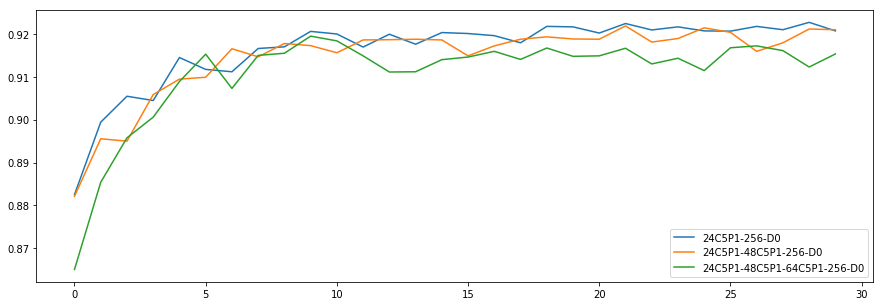

In [12]:
# configurations of each of the model
model_confs = [
    {"feature_maps": [24], "kernel_size": 5, "dense_size": [256], "drop_rate": 0.0},
    {"feature_maps": [24, 48], "kernel_size": 5, "dense_size": [256], "drop_rate": 0.0},
    {"feature_maps": [24, 48, 64], "kernel_size": 5, "dense_size": [256], "drop_rate": 0.0}
]

cnn_models = CNN_Modeling(model_confs)

cnn_models.train_models(X_train, y_train, X_val, y_val)

cnn_models.plot_accuracy_chart()

So, this concludes that the model with 2 convolution layers performed slightly better than models with 1 or 3 layers

### Experiment 2
Change the number of feature maps

CNN 8C5P1-16C5P1-256-D0: Epochs=30, Train accuracy=0.99267, Validation accuracy=0.91578
CNN 16C5P1-32C5P1-256-D0: Epochs=30, Train accuracy=0.99912, Validation accuracy=0.92228
CNN 32C5P1-64C5P1-256-D0: Epochs=30, Train accuracy=1.00000, Validation accuracy=0.92483
CNN 64C5P1-128C5P1-256-D0: Epochs=30, Train accuracy=1.00000, Validation accuracy=0.92772


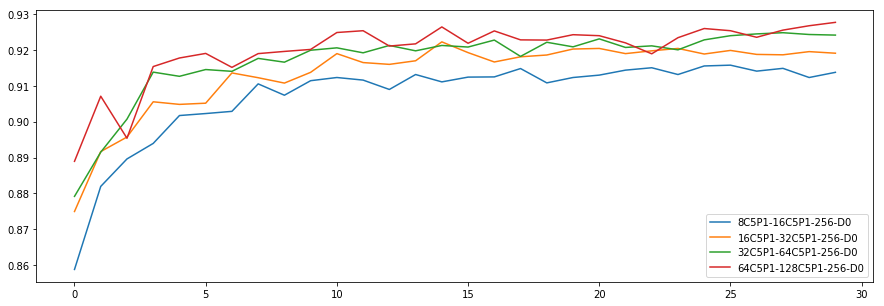

In [13]:
# configurations of each of the model
model_confs = [
    {"feature_maps": [8, 16], "kernel_size": 5, "dense_size": [256], "drop_rate": 0.0},
    {"feature_maps": [16, 32], "kernel_size": 5, "dense_size": [256], "drop_rate": 0.0},
    {"feature_maps": [32, 64], "kernel_size": 5, "dense_size": [256], "drop_rate": 0.0},
    {"feature_maps": [64, 128], "kernel_size": 5, "dense_size": [256], "drop_rate": 0.0}
]

cnn_models = CNN_Modeling(model_confs)

cnn_models.train_models(X_train, y_train, X_val, y_val)

cnn_models.plot_accuracy_chart()

So, the model with feature maps 64, 128 outperformed all the others.

### Experiment 3
Change the size of the Dense layers

In [14]:
# will be creating 8 models with following sizes
[(2**(i+4)*(i!=0)) for i in range(8)]

[0, 32, 64, 128, 256, 512, 1024, 2048]

In [15]:
# configuration of each of the model
model_confs = [
    {"feature_maps": [64, 128], "kernel_size": 5, "dense_size": [2**(i+4)*(i!=0)], "drop_rate": 0.0} for i in range(8)
]

for each in model_confs:
    print(each)

{'feature_maps': [64, 128], 'kernel_size': 5, 'dense_size': [0], 'drop_rate': 0.0}
{'feature_maps': [64, 128], 'kernel_size': 5, 'dense_size': [32], 'drop_rate': 0.0}
{'feature_maps': [64, 128], 'kernel_size': 5, 'dense_size': [64], 'drop_rate': 0.0}
{'feature_maps': [64, 128], 'kernel_size': 5, 'dense_size': [128], 'drop_rate': 0.0}
{'feature_maps': [64, 128], 'kernel_size': 5, 'dense_size': [256], 'drop_rate': 0.0}
{'feature_maps': [64, 128], 'kernel_size': 5, 'dense_size': [512], 'drop_rate': 0.0}
{'feature_maps': [64, 128], 'kernel_size': 5, 'dense_size': [1024], 'drop_rate': 0.0}
{'feature_maps': [64, 128], 'kernel_size': 5, 'dense_size': [2048], 'drop_rate': 0.0}


CNN 64C5P1-128C5P1-0-D0: Epochs=30, Train accuracy=0.99976, Validation accuracy=0.92267
CNN 64C5P1-128C5P1-32-D0: Epochs=30, Train accuracy=0.99998, Validation accuracy=0.92272
CNN 64C5P1-128C5P1-64-D0: Epochs=30, Train accuracy=1.00000, Validation accuracy=0.92783
CNN 64C5P1-128C5P1-128-D0: Epochs=30, Train accuracy=1.00000, Validation accuracy=0.92906
CNN 64C5P1-128C5P1-256-D0: Epochs=30, Train accuracy=1.00000, Validation accuracy=0.92589
CNN 64C5P1-128C5P1-512-D0: Epochs=30, Train accuracy=1.00000, Validation accuracy=0.92867
CNN 64C5P1-128C5P1-1024-D0: Epochs=30, Train accuracy=1.00000, Validation accuracy=0.92722
CNN 64C5P1-128C5P1-2048-D0: Epochs=30, Train accuracy=1.00000, Validation accuracy=0.92944


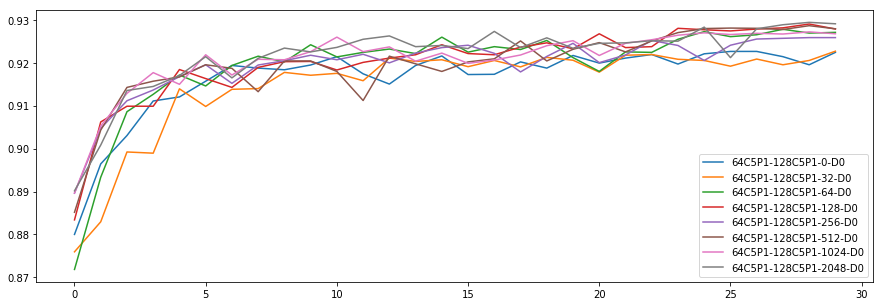

In [16]:
cnn_models = CNN_Modeling(model_confs)

cnn_models.train_models(X_train, y_train, X_val, y_val)

cnn_models.plot_accuracy_chart()

So, we have the best accuracy from the model with 512 nodes in the Dense layer

### Experiment 4
Chaning different drop out rates

In [17]:
# will be creating 8 models with following dropouts
print([round(0.1*i,2) for i in range(8)])

[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]


In [18]:
# configuration of each of the model
model_confs = [
    {"feature_maps": [64, 128], "kernel_size": 5, "dense_size": [512], "drop_rate": round(0.1*i,2)} for i in range(8)
]

for each in model_confs:
    print(each)

{'feature_maps': [64, 128], 'kernel_size': 5, 'dense_size': [512], 'drop_rate': 0.0}
{'feature_maps': [64, 128], 'kernel_size': 5, 'dense_size': [512], 'drop_rate': 0.1}
{'feature_maps': [64, 128], 'kernel_size': 5, 'dense_size': [512], 'drop_rate': 0.2}
{'feature_maps': [64, 128], 'kernel_size': 5, 'dense_size': [512], 'drop_rate': 0.3}
{'feature_maps': [64, 128], 'kernel_size': 5, 'dense_size': [512], 'drop_rate': 0.4}
{'feature_maps': [64, 128], 'kernel_size': 5, 'dense_size': [512], 'drop_rate': 0.5}
{'feature_maps': [64, 128], 'kernel_size': 5, 'dense_size': [512], 'drop_rate': 0.6}
{'feature_maps': [64, 128], 'kernel_size': 5, 'dense_size': [512], 'drop_rate': 0.7}


CNN 64C5P1-128C5P1-512-D0: Epochs=30, Train accuracy=1.00000, Validation accuracy=0.93017
CNN 64C5P1-128C5P1-512-D10: Epochs=30, Train accuracy=0.99874, Validation accuracy=0.92822
CNN 64C5P1-128C5P1-512-D20: Epochs=30, Train accuracy=0.99557, Validation accuracy=0.93017
CNN 64C5P1-128C5P1-512-D30: Epochs=30, Train accuracy=0.98733, Validation accuracy=0.93189
CNN 64C5P1-128C5P1-512-D40: Epochs=30, Train accuracy=0.97217, Validation accuracy=0.93111
CNN 64C5P1-128C5P1-512-D50: Epochs=30, Train accuracy=0.95302, Validation accuracy=0.93356
CNN 64C5P1-128C5P1-512-D60: Epochs=30, Train accuracy=0.93029, Validation accuracy=0.92944
CNN 64C5P1-128C5P1-512-D70: Epochs=30, Train accuracy=0.90362, Validation accuracy=0.92122


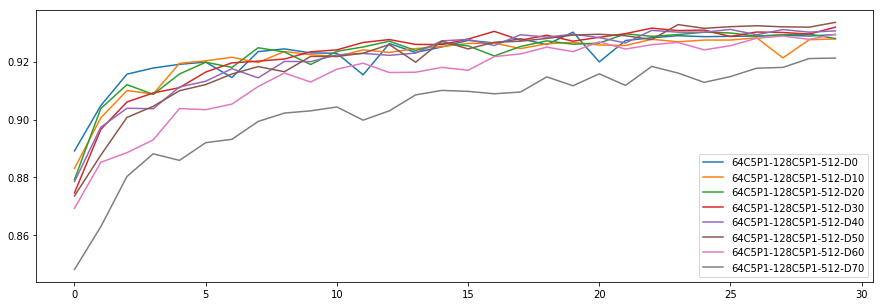

In [19]:
cnn_models = CNN_Modeling(model_confs)

cnn_models.train_models(X_train, y_train, X_val, y_val)

cnn_models.plot_accuracy_chart()

Best Validation accuracy we got is 93% but the train accuracy went down significantly i.e. 93%. So, optimal model with good train and validation accuracy both was with 20% drop out rate.

# Prediction

CNN 64C5P1-128C5P1-512-D20: Epochs=30, Train accuracy=0.99605, Validation accuracy=0.92928


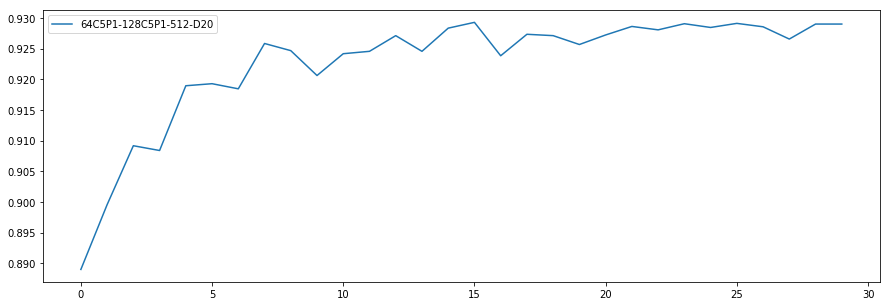

In [20]:
# configuration of each of the model
model_confs = [{"feature_maps": [64, 128], "kernel_size": 5, "dense_size": [512], "drop_rate": 0.2}]

cnn_models = CNN_Modeling(model_confs)

cnn_models.train_models(X_train, y_train, X_val, y_val)

cnn_models.plot_accuracy_chart()

Shape of X:  (10000, 28, 28, 1)
Sample of X: 


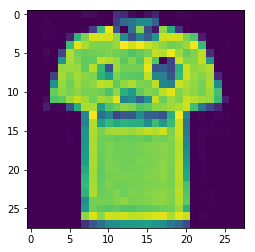

In [21]:
predict_df = pd.read_csv(data_dir+"fashion-mnist_test.csv")

# get the labels of the data
labels_predict = predict_df.values[:, 0]

# extract the pixel values from the dataframe
X_predict = predict_df.values[:, 1:]/255.0 # all the columns but 1st

# reshape each row into 28x28 size
X_predict = X_predict.reshape(-1, 28, 28, 1) # -1 tells the system to automatically figure out the size of the first dimention

print("Shape of X: ", X_predict.shape)
print("Sample of X: ")
plt.imshow(X_predict[0].reshape(28, 28))

In [22]:
predicted_labels = cnn_models.predict("64C5P1-128C5P1-512-D20", X_predict)

In [23]:
print("Predicted Accuracy is: %.1f%%" % (accuracy_score(labels_predict, predicted_labels)*100))

Predicted Accuracy is: 93.1%
